# ADMAGD - Evaluation

## Importing libraries

In [6]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups

from collections import defaultdict
import re
from string import punctuation

## Fetch Test Data

In [7]:
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc' ]

In [8]:
newsgroups = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## Pre-processing

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS # Total 318 words

import nltk
nltk.download('punkt')
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger') # need for pos_tag

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Alam\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alam\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
nltk_stop_words = list(set(stopwords.words('english')))
sk_stop_words = list(ENGLISH_STOP_WORDS)

STOP_WORDS = list(set(nltk_stop_words + sk_stop_words))
STOP_WORDS += ["use", "think", "thanks", "know", "like", "make", "say", "time", "use", "need", "want", "come" ]

# Initialization
lemmatizer = WordNetLemmatizer()

# Creating a POS tag map
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def convertWordIntoLemmatizeWord(words):
  return [lemmatizer.lemmatize(word, tag_map[tag[0]]) for word, tag in pos_tag(words)]
def preprocess(words):
  #First, remove numbers
  words = [re.sub(r"\d+", "", word) for word in words]
  #Normalize the cases of our words
  words = [word.lower() for word in words]
  #Remove all punctuations
  table = str.maketrans('', '', punctuation)
  words = [word.translate(table) for word in words]
  #Some white spaces may be added to the list of words, due to the translate function & nature of our documents. We've to remove them.
  words = [word for word in words if word]
  #Remove just-numeric strings
  words = [word for word in words if not word.isdigit()]
  #Remove all stop words
  words = [word for word in words if word not in STOP_WORDS]
  #Lemmatize
  words = convertWordIntoLemmatizeWord(words)
  #Remove all stop words
  words = [word for word in words if word not in STOP_WORDS]
  #Remove words with less than 3 characters and more than 20 characters
  words = [word for word in words if len(word) > 2 and len(word) <= 20]
  return words
def preprocess_documents(docs):
  preprocessed_docs = []
  for doc in docs:
    words = word_tokenize(doc)
    words = preprocess(words)
    # preprocessed_docs.append(" ".join(words))
    preprocessed_docs.append(words)
  return preprocessed_docs
preprocessed_docs = preprocess_documents(newsgroups.data)

In [11]:
from gensim import corpora, models


In [12]:
dictionary = corpora.Dictionary(preprocessed_docs)

In [13]:
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [14]:
test_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

In [15]:
len(test_corpus)

7532

In [16]:
tfidf = models.TfidfModel(test_corpus)

In [17]:
corpus_tfidf = tfidf[test_corpus]

## Retrieve Model

In [18]:
model_file_name = "tfidf_train_extra_stopwords_200_iteration_admagd_model"

In [19]:
model_path = f"trained_ model/{model_file_name}"

### Pickle

In [20]:
import pickle

Load the model from a file

In [21]:
with open(f"{model_path}.pkl", 'rb') as f:
    loaded_model = pickle.load(f)

## Coherence Score

In [22]:
from gensim.models.coherencemodel import CoherenceModel

In [23]:
# After you've run Gibbs sampling
word_topic_matrix = loaded_model.word_topic_matrix
word_topic_sum = word_topic_matrix.sum(axis=1)[:, np.newaxis]
word_topic_dist = word_topic_matrix / word_topic_sum

In [24]:
list_of_top_words_number = [5, 10, 15, 20, 25, 30]
list_of_coherence_score = []

In [25]:
def calculate_coherence_score(N_TOP_WORDS = 10):
  # Get the top words for each topic
  ALL_TOPIC_WORDS = []
  for i in range(loaded_model.num_topics):
      top_words_idx = word_topic_dist[i].argsort()[-N_TOP_WORDS:][::-1]
      top_words = [loaded_model.id2word[idx] for idx in top_words_idx]

      ALL_TOPIC_WORDS.append(top_words)

  # Compute Coherence Score
  coherence_model = CoherenceModel(topics=ALL_TOPIC_WORDS, corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass')

  coherence_score = coherence_model.get_coherence()

  return coherence_score

In [26]:
for number in list_of_top_words_number:
  score = calculate_coherence_score(number)
  list_of_coherence_score.append(score)

In [27]:
list_of_coherence_score

[-1.6876218721129619,
 -1.7348499910829063,
 -1.9397403118554617,
 -2.0130396308280463,
 -1.9822541256852328,
 -1.9673857174804563]

In [28]:
import matplotlib.pyplot as plt

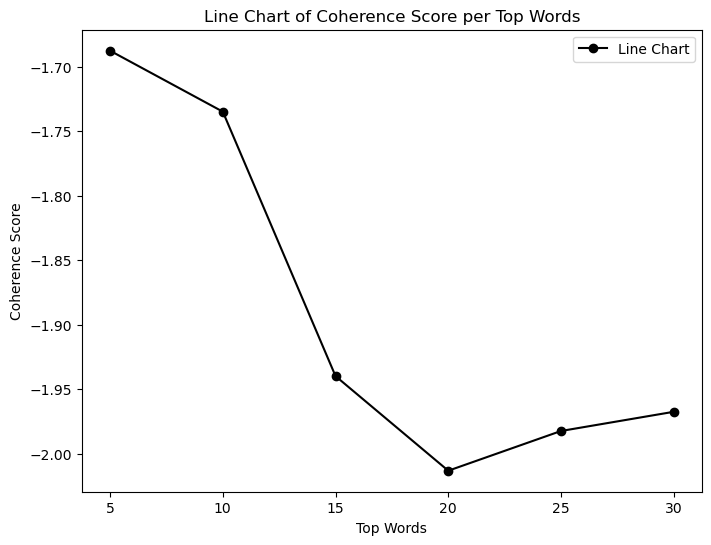

In [64]:
plt.figure(figsize=(8, 6))  # Set the size of the chart (optional)

# Create a line chart using the `plot` function
plt.plot(list_of_top_words_number, list_of_coherence_score, marker='o', linestyle='-', color='black', label='Line Chart')

# Add labels and a title
plt.xlabel('Top Words')
plt.ylabel('Coherence Score')
plt.title('Line Chart of Coherence Score per Top Words')

# Add a legend (if multiple lines are present)
plt.legend()

# Show the chart
plt.show()


## Heatmap

In [33]:
import seaborn as sns

In [35]:
# Normalize the Author-Topic Matrix
normalized_author_topic_matrix = loaded_model.calculate_theta_update()

In [53]:
# Convert to DataFrame for easier plotting
author_names = loaded_model.authors
topic_names = [str(i+1) for i in range(loaded_model.num_topics)]
df = pd.DataFrame(normalized_author_topic_matrix, index=author_names, columns=topic_names)

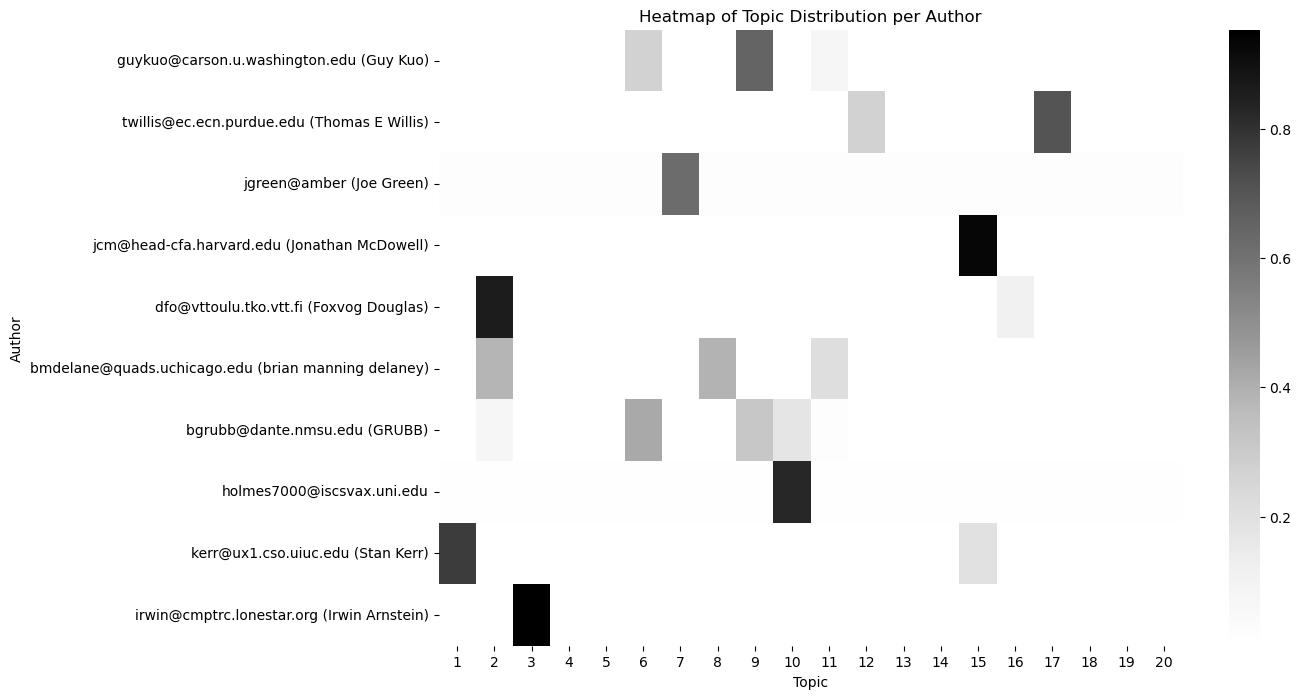

In [61]:
# Plotting the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[1:11], cmap="Greys")
plt.title('Heatmap of Topic Distribution per Author')
plt.ylabel('Author')
plt.xlabel('Topic')
plt.show()